Скачиваем данные, импортируем библиотеки

In [1]:
!pip install catboost
!pip install optuna
!pip install gdown

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRanker, Pool, MetricVisualizer, EShapCalcType, EFeaturesSelectionAlgorithm
from sklearn.metrics import ndcg_score
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import torch
import optuna

In [3]:
!gdown 17lnDRn-7sqM4hOO-OvFXOeLPBYSkDW7t

Downloading...
From (original): https://drive.google.com/uc?id=17lnDRn-7sqM4hOO-OvFXOeLPBYSkDW7t
From (redirected): https://drive.google.com/uc?id=17lnDRn-7sqM4hOO-OvFXOeLPBYSkDW7t&confirm=t&uuid=ef8f7df5-6309-4e57-91f0-82211ada870c
To: /kaggle/working/intern_task.csv
100%|█████████████████████████████████████████| 222M/222M [00:01<00:00, 159MB/s]


In [4]:
df = pd.read_csv("intern_task.csv")

In [5]:
df.head()

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
0,0,10,1.0,0.0,1.0,3.0,3.0,0.333333,0.0,0.333333,...,0.0,0.000000,0.454545,0.890238,8.655534,1.000000,0.077778,0.002222,1.0,0.333333
1,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.773976,23.130514,0.000000,0.027826,0.000430,44.0,14.666667
2,0,10,3.0,0.0,2.0,0.0,3.0,1.000000,0.0,0.666667,...,0.0,0.000000,0.000000,0.918308,13.351339,0.000000,0.014925,0.000104,22.0,7.333333
3,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.975355,18.240926,0.000000,0.053140,0.000255,8.0,2.666667
4,2,10,3.0,0.0,3.0,1.0,3.0,1.000000,0.0,1.000000,...,273.0,79.670665,0.200000,0.990119,31.786048,0.333333,0.046512,0.000307,24.0,8.000000


Проверяем, есть ли наны в данных

In [6]:
df.isnull().sum().sum()

0

Далее для ранжирования я буду использовать градиентный бустинг. Основная проблема в том, что размерность признаков очень большая. Из-за этого данные не влезают на gpu, а на cpu один алгоритм учится очень долго (около 4 часов при количестве деревьев 500). Так как для подбора хороших гиперпараметров с помощью optuna необходимо много запусков (~100), нам необходимо ускорить процесс обучения и уменьшить количество потребляемой памяти.

Уберем малоинформативные признаки с помощью RFE, чтобы ускорить работу

Разделим на тренировочную и валидационную выборку

In [7]:
unique_queries = df["query_id"].unique()
indexes = set(np.random.choice(unique_queries, size=int(0.8 * len(unique_queries)),
                               replace=False))

df_train = df[df['query_id'].isin(indexes)]
df_val = df[~df['query_id'].isin(indexes)]

In [8]:
x_train = df_train.drop(labels=["rank", "query_id"], axis=1)
y_train = df_train["rank"]

x_val = df_val.drop(labels=["rank", "query_id"], axis=1)
y_val = df_val["rank"]

queries_train = df_train["query_id"]
queries_val = df_val["query_id"]

Для расчета метрики NDCG and PFound ранг должен быть в диапазоне [0,1]

In [9]:
max_relevance = np.max(y_train)
y_train /= max_relevance
y_val /= max_relevance

In [10]:
train = Pool(
    data=x_train.values,
    label=y_train.values,
    group_id=queries_train.values
)

val = Pool(
    data=x_val.values,
    label=y_val.values,
    group_id=queries_val.values
)

Проверим как ведет себя лосс при удалении фичей

In [11]:
def select_features(algorithm, num_of_features, steps: int = 1):
    param = {
        "gpu_ram_part": 0.3,
        "loss_function": "PairLogitPairwise",
        "iterations": 200,
        "depth": 6
    }
    task_type = "GPU" if torch.cuda.is_available() else "CPU"
    model = CatBoostRanker(task_type=task_type, **param)
    summary = model.select_features(
        train,
        eval_set=val,
        features_for_select=list(range(x_train.shape[1])),
        num_features_to_select=num_of_features,
        steps=steps,
        algorithm=algorithm,
        shap_calc_type=EShapCalcType.Regular,
        train_final_model=False,
        logging_level='Silent',
        plot=True
    )
    return summary

In [ ]:
synthetic_shap_summary = select_features(EFeaturesSelectionAlgorithm.RecursiveByShapValues, 20, 3)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Видно, что после 104 убранных фич лосс начинает сильно расти. Тогда возьмем топ 40 фичей

In [ ]:
summary = select_features(EFeaturesSelectionAlgorithm.RecursiveByShapValues, 40, 3)

In [12]:
# columns = summary["selected_features"]

# сохраним отдельно столбцы
columns = [2, 7, 10, 12, 13, 14, 24, 29, 47, 49, 52, 54, 57, 59, 60, 62, 69, 71,
           78, 83, 88, 106, 107, 108, 109, 112, 114, 118, 119, 122, 126, 128,
           129, 130, 132, 133, 136, 137, 138, 140]

In [13]:
x_train = x_train.iloc[:, columns]
x_val = x_val.iloc[:, columns]

train = Pool(
    data=x_train.values,
    label=y_train.values,
    group_id=queries_train.values
)

val = Pool(
    data=x_val.values,
    label=y_val.values,
    group_id=queries_val.values
)

In [19]:
def objective(trial: optuna.Trial):

    device = "GPU" if torch.cuda.is_available() else "CPU"
    param = {
        "loss_function": trial.suggest_categorical("loss_function", ["PairLogitPairwise",
                                                                     "YetiRankPairwise"]),
        "gpu_ram_part": 0.3,
        "eval_metric": "NDCG:top=5",
        'iterations': trial.suggest_int("iterations", 10, 1000),
        "depth": trial.suggest_int("depth", 1, 8),
        "boosting_type": "Plain",
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian",
                                                                       "Bernoulli"]),
        "task_type": device,
        "logging_level": "Silent"
    }
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 0.8)

    model = CatBoostRanker(**param)
    model.fit(train, eval_set=val)
    return model.get_evals_result()['validation']['NDCG:top=5;type=Base'][-1]

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2024-04-29 14:10:08,861] A new study created in memory with name: no-name-4235a9b2-9a93-4e21-86f0-152a30ee26e6

Default metric period is 5 because PFound, NDCG is/are not implemented for GPU

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time

Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time

[I 2024-04-29 14:10:13,391] Trial 0 finished with value: 0.5064861780675394 and parameters: {'loss_function': 'YetiRankPairwise', 'iterations': 413, 'depth': 1, 'bootstrap_type': 'Bernoulli', 'subsample': 0.7279056929930241}. Best is trial 0 with value: 0.5064861780675394.

Default metric period is 5 because PFound, NDCG is/are not implemented for GPU

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time

Metric NDCG:top=5;type=Base is not implemented on GPU. Will u

Параметры лучшей попытки: {'loss_function': 'PairLogitPairwise', 'iterations': 672, 'depth': 6, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.6387904684815577}

In [21]:
# trial = study.best_trial
# trial.params

device = "GPU" if torch.cuda.is_available() else "CPU"
params = {'iterations': 672,
          "task_type": device,
          "logging_level": "Silent",
          "gpu_ram_part": 0.3,
          "loss_function": "PairLogitPairwise",
          'depth': 6,
          'bootstrap_type': 'Bayesian',
          'bagging_temperature': 2.6387904684815577,
          "boosting_type": "Plain",
          "custom_metric": ["NDCG:top=5", "PFound:top=5", "ERR:top=5"]
    }

In [22]:
model = CatBoostRanker(**params)
model.fit(train, eval_set=val)
metrics = model.get_evals_result()['validation']

Default metric period is 5 because PFound, NDCG, ERR is/are not implemented for GPU

Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time

Metric PFound:top=5 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time

Metric ERR:top=5 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


In [25]:
print(f"PFound = {metrics['PFound:top=5'][-1]}\n"
      f"NDCG = {metrics['NDCG:top=5;type=Base'][-1]}\n",
      f"ERR = {metrics['ERR:top=5'][-1]}\n",
      f"PairLogitLoss = {metrics['PairLogit'][-1]}\n")

PFound = 0.6631355121765139

NDCG = 0.5543816498545664

 ERR = 0.5252747395833335

 PairLogitLoss = 0.6160986574753132




Так как нет хорошего описания признаков, попробуем найти закономерности в данных при помощи объединения по кластерам. Нахождение происходит по части train выборки, так как вся выборка не влезла в память. Нахождение по 50 тысячам объектов съедает 18 гб памяти. По val выборке искать не стал, так как это была бы утечка информации

In [14]:
x_train_mini = x_train.iloc[:50000]
sc = StandardScaler()
sc.fit(x_train.values)
x_train_mini_sc = sc.transform(x_train_mini.values)

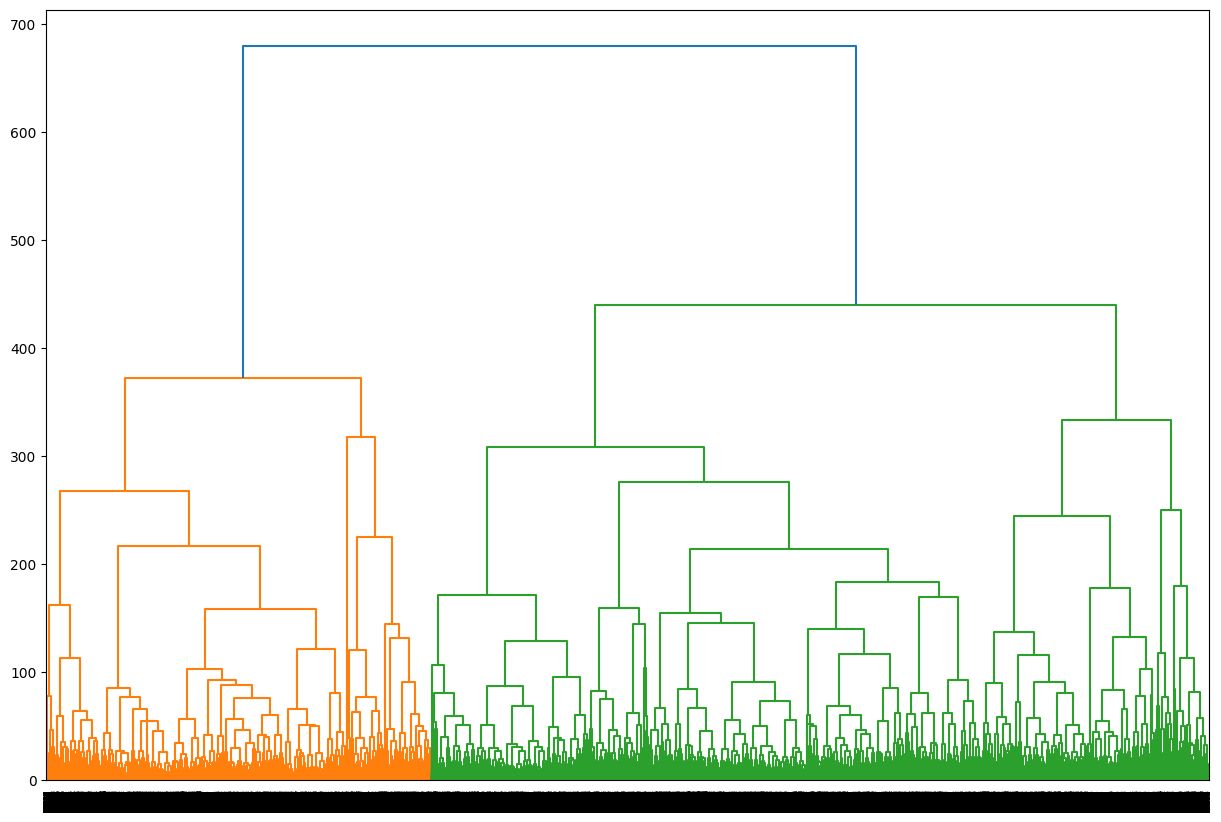

In [ ]:
linked = linkage(x_train_mini_sc, method="ward")
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation="top")
plt.show()

Алгоритм выделил 2 кластера

In [16]:
km = KMeans(n_clusters=2)
x_train_sc = sc.transform(x_train.values)
x_val_sc = sc.transform(x_val.values)

labels_train = km.fit_predict(x_train_sc)
labels_val = km.predict(x_val_sc)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [17]:
x_train["cluster"] = labels_train
x_val["cluster"] = labels_val

In [18]:
train = Pool(
    data=x_train.values,
    label=y_train.values,
    group_id=queries_train.values
)

val = Pool(
    data=x_val.values,
    label=y_val.values,
    group_id=queries_val.values
)

In [19]:
def objective(trial: optuna.Trial):

    device = "GPU" if torch.cuda.is_available() else "CPU"
    param = {
        "loss_function": "PairLogitPairwise",
        "gpu_ram_part": 0.3,
        "eval_metric": "NDCG:top=5",
        'iterations': trial.suggest_int("iterations", 10, 1000),
        "depth": trial.suggest_int("depth", 1, 8),
        "boosting_type": "Plain",
        "bootstrap_type": "Bayesian",
        "task_type": device,
        "logging_level": "Silent",
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 10)
    }

    model = CatBoostRanker(**param)
    model.fit(train, eval_set=val)
    return model.get_evals_result()['validation']['NDCG:top=5;type=Base'][-1]

In [20]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2024-04-29 18:57:52,010] A new study created in memory with name: no-name-61e041e3-94f1-4543-9e9c-4242d54a0d20
Default metric period is 5 because NDCG is/are not implemented for GPU
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-04-29 19:00:30,805] Trial 0 finished with value: 0.5521262456189624 and parameters: {'iterations': 976, 'depth': 7, 'bagging_temperature': 7.43415122903078}. Best is trial 0 with value: 0.5521262456189624.
Default metric period is 5 because NDCG is/are not implemented for GPU
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-04-29 19:00:38,719] Trial 1 finished with value: 0.5160255278836066 and parameters: {'iterations': 290, 'depth': 2, 'bagging_temperature': 1.3919155845563747}. Best is trial 0 with value: 0.5521262456189624.
Default metric period is 5 because NDC

KeyboardInterrupt: 

Параметры лучшей попытки: {'iterations': 752, 'depth': 8, 'bagging_temperature': 0.6834296109880613}

In [22]:
# trial = study.best_trial
# trial.params

device = "GPU" if torch.cuda.is_available() else "CPU"
params = {'iterations': 752,
          "task_type": device,
          "logging_level": "Silent",
          "gpu_ram_part": 0.3,
          "loss_function": "PairLogitPairwise",
          'depth': 8,
          'bootstrap_type': 'Bayesian',
          'bagging_temperature': 0.6834296109880613,
          "boosting_type": "Plain",
          "custom_metric": ["NDCG:top=5", "PFound:top=5", "ERR:top=5"]
    }

model = CatBoostRanker(**params)
model.fit(train, eval_set=val)
metrics = model.get_evals_result()['validation']

Default metric period is 5 because PFound, NDCG, ERR is/are not implemented for GPU
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound:top=5 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric ERR:top=5 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


In [23]:
print(f"PFound = {metrics['PFound:top=5'][-1]}\n"
      f"NDCG = {metrics['NDCG:top=5;type=Base'][-1]}\n",
      f"ERR = {metrics['ERR:top=5'][-1]}\n",
      f"PairLogitLoss = {metrics['PairLogit'][-1]}\n")

PFound = 0.6706245832977293
NDCG = 0.5610565188904849
 ERR = 0.5335901692708331
 PairLogitLoss = 0.6246990980694996



Получились значения несильно лучше, но все же подросли